<a href="https://colab.research.google.com/github/DariiaKhoroshchuk/deep_learning_labs/blob/master/Lab5_Dariia_Khoroshchuk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usecase 1: Simple LSTM for text classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, pad_sequences
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AIS/DL/2022-23/practice/Lab5/spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.columns = ['label', 'message']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Number of ham and spam messages')

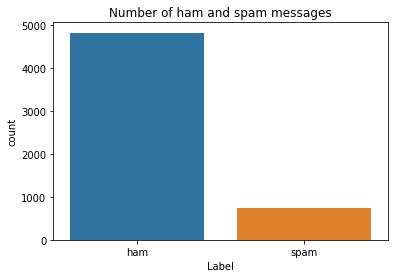

In [ ]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [ ]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

In [ ]:
X = df.message
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

Обробка даних:

* Токенізування даних та перетворення тексту у послідовності. 
* Додавання відступів, щоб усі послідовності мали однакову форму.

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

## Initial model

RNN

In [ ]:
def RNN():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 11s 297ms/step - loss: 0.3211 - accuracy: 0.8770 - val_loss: 0.1311 - val_accuracy: 0.9652
Epoch 2/10
30/30 [==============================] - 8s 281ms/step - loss: 0.0840 - accuracy: 0.9786 - val_loss: 0.0585 - val_accuracy: 0.9831


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 22ms/step - loss: 0.0477 - accuracy: 0.9844


In [ ]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.048
 Accuracy: 0.984


In [ ]:
import plotly.figure_factory as ff

x_axes = ['Ham', 'Spam']
y_axes =  ['Spam', 'Ham']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [ ]:
from sklearn import metrics
Y_pred = (model.predict(test_sequences_matrix)>0.5).astype(int)
print(metrics.accuracy_score(Y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(Y_test, Y_pred))

27/27 [==============================] - 1s 24ms/step
0.9844497607655502


## Changed models

### Without preprocesing

In [ ]:
def RNN1():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,100,input_length=max_len)(inputs)  # 50 --> 100
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
model1 = RNN1()
model1.summary()
model1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 150, 100)          100000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
model1.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 16s 420ms/step - loss: 0.2872 - accuracy: 0.8875 - val_loss: 0.1107 - val_accuracy: 0.9778
Epoch 2/10
30/30 [==============================] - 10s 332ms/step - loss: 0.0632 - accuracy: 0.9844 - val_loss: 0.0591 - val_accuracy: 0.9873


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model1.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 26ms/step - loss: 0.0617 - accuracy: 0.9821


In [ ]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.062
 Accuracy: 0.982


In [ ]:
from sklearn import metrics
Y_pred = (model1.predict(test_sequences_matrix)>0.5).astype(int)
print(metrics.accuracy_score(Y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(Y_test, Y_pred))

27/27 [==============================] - 1s 26ms/step
0.9820574162679426


In [ ]:
def RNN2():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,10,input_length=max_len)(inputs)  # 50 --> 10
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
model2 = RNN2()
model2.summary()
model2.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 150, 10)           10000     
                                                                 
 lstm_5 (LSTM)               (None, 64)                19200     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_10 (Activation)  (None, 256)               0         
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
model2.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 10s 263ms/step - loss: 0.4238 - accuracy: 0.8506 - val_loss: 0.2858 - val_accuracy: 0.8639
Epoch 2/10
30/30 [==============================] - 7s 247ms/step - loss: 0.2031 - accuracy: 0.9258 - val_loss: 0.1063 - val_accuracy: 0.9810


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model2.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 20ms/step - loss: 0.0947 - accuracy: 0.9773


In [ ]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.095
 Accuracy: 0.977


In [ ]:
from sklearn import metrics
Y_pred = (model2.predict(test_sequences_matrix)>0.5).astype(int)
print(metrics.accuracy_score(Y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(Y_test, Y_pred))

27/27 [==============================] - 1s 20ms/step
0.9772727272727273


Without Dropout

In [ ]:
def RNN3():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
model3 = RNN3()
model3.summary()
model3.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                                 
 activation_1 (Activation)   (None, 1)                 0     

In [ ]:
model3.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 11s 266ms/step - loss: 0.4833 - accuracy: 0.8413 - val_loss: 0.2986 - val_accuracy: 0.8681
Epoch 2/10
30/30 [==============================] - 7s 244ms/step - loss: 0.1769 - accuracy: 0.9234 - val_loss: 0.0603 - val_accuracy: 0.9831


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model3.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 21ms/step - loss: 0.0913 - accuracy: 0.9809


In [ ]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.091
 Accuracy: 0.981


In [ ]:
from sklearn import metrics
Y_pred = (model3.predict(test_sequences_matrix)>0.5).astype(int)
print(metrics.accuracy_score(Y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(Y_test, Y_pred))

27/27 [==============================] - 1s 35ms/step
0.9808612440191388


Only one dence layer

Result: bad classification

In [ ]:
def RNN4():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
model4 = RNN4()
model4.summary()
model4.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_4 (LSTM)               (None, 64)                29440     
                                                                 
 activation_8 (Activation)   (None, 64)                0         
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 out_layer (Dense)           (None, 1)                 65        
                                                                 
 activation_9 (Activation)   (None, 1)                 0   

In [ ]:
model4.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
30/30 [==============================] - 11s 306ms/step - loss: 0.5172 - accuracy: 0.8561 - val_loss: 0.3878 - val_accuracy: 0.8681
Epoch 2/10
30/30 [==============================] - 9s 291ms/step - loss: 0.3795 - accuracy: 0.8677 - val_loss: 0.2909 - val_accuracy: 0.8703


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model3.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 21ms/step - loss: 0.0913 - accuracy: 0.9809


In [ ]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.091
 Accuracy: 0.981


In [ ]:
from sklearn import metrics
Y_pred = (model4.predict(test_sequences_matrix)>0.5).astype(int)
print(metrics.accuracy_score(Y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(Y_test, Y_pred))

27/27 [==============================] - 1s 20ms/step
0.8564593301435407


+1 Dence layer, +1 LSTM, patience=1

In [ ]:
def RNN5():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64, return_sequences=True)(layer)
  layer = LSTM(32)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.3)(layer)
  layer = Dense(128,name='FC2')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
model5 = RNN5()
model5.summary()
model5.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_11 (Embedding)    (None, 150, 50)           50000     
                                                                 
 lstm_12 (LSTM)              (None, 150, 64)           29440     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 FC1 (Dense)                 (None, 256)               8448      
                                                                 
 activation_28 (Activation)  (None, 256)               0         
                                                                 
 dropout_15 (Dropout)        (None, 256)               0  

In [ ]:
model5.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=1)])

Epoch 1/10
30/30 [==============================] - 17s 418ms/step - loss: 0.4069 - accuracy: 0.8577 - val_loss: 0.2095 - val_accuracy: 0.8681
Epoch 2/10
30/30 [==============================] - 11s 379ms/step - loss: 0.1404 - accuracy: 0.9506 - val_loss: 0.0514 - val_accuracy: 0.9873
Epoch 3/10
30/30 [==============================] - 11s 379ms/step - loss: 0.0447 - accuracy: 0.9886 - val_loss: 0.0550 - val_accuracy: 0.9873


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model5.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 1s 34ms/step - loss: 0.0808 - accuracy: 0.9821


In [ ]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.081
 Accuracy: 0.982


In [ ]:
from sklearn import metrics
Y_pred = (model5.predict(test_sequences_matrix)>0.5).astype(int)
print(metrics.accuracy_score(Y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(Y_test, Y_pred))

27/27 [==============================] - 2s 35ms/step
0.9820574162679426


### Data preprocessing

**Data explodation**

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
#Adding a column of numbers of charachters,words and sentences in each msg
df["num_of_characters"] = df["message"].apply(len)
df["num_of_words"]=df.apply(lambda row: nltk.word_tokenize(row["message"]), axis=1).apply(len)
df["num_of_sentence"]=df.apply(lambda row: nltk.sent_tokenize(row["message"]), axis=1).apply(len)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_of_characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
num_of_words,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
num_of_sentence,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


<Figure size 864x576 with 0 Axes>

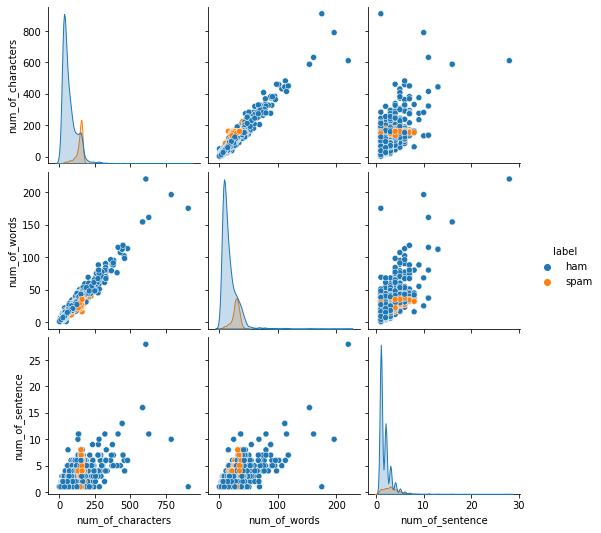

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="label")
plt.show(fg)

Dropping the outliers

In [ ]:
df = df[(df["num_of_characters"]<450)]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


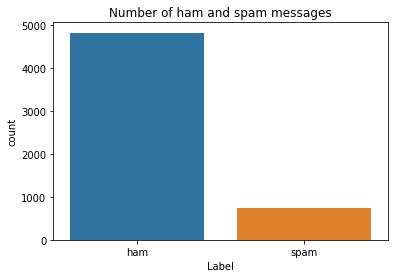

In [ ]:
sns.countplot(df.label)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')
plt.show()

Cleaning text

In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [ ]:
#Lets have a look at a sample of texts before cleaning
print("The First 5 Texts:",*df["message"][:5], sep = "\n")

The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [ ]:
# extrect only alphabetical characters
import re

# defining a function to clean up the text
def clean_text(text):
    new_text = re.sub('[^a-zA-Z]', ' ', text) # replacing all non-alphabetic characters with a space
    new_text = new_text.lower() #converting to lowecase
    new_text = new_text.split()
    new_text = ' '.join(new_text)
    return new_text

df["clean_text"] = df["message"].apply(clean_text)
#Lets have a look at a sample of texts after cleaning
print("The First 5 Texts after cleaning:",*df["clean_text"][:5], sep = "\n")

The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [ ]:
import string

stop_words = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

df["clean_text"] = df["clean_text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
print("The First 5 Texts after cutting stopwords:",*df["clean_text"][:5], sep = "\n")

The First 5 Texts after cutting stopwords:
go jurong point crazy available bugis n great world la e buffet cine got amore wat
ok lar joking wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think goes usf lives around though


In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return lemmas

df["lemmatized_text"] = df["clean_text"].apply(lemmatize_word).apply(lambda x: " ".join(x))
# df["lemmatized_text"] = df["lemmatized_text"].apply(lambda x: " ".join(x))
print("The First 5 Texts after lemitization:",*df["lemmatized_text"][:5], sep = "\n")

The First 5 Texts after lemitization:
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [ ]:
df.loc[:, ("label", "message", "lemmatized_text")].head()

,label,message,lemmatized_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live around though


**Models**

In [ ]:
X = df.lemmatized_text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [ ]:
max_words = 1000
max_len = df["num_of_characters"].max()
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [ ]:
def RNN6():
  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64, return_sequences=True)(layer)
  layer = LSTM(32)(layer)
  layer = Dropout(0.2)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(1,name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
model6 = RNN6()
model6.summary()
model6.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 444)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 444, 50)           50000     
                                                                 
 lstm_2 (LSTM)               (None, 444, 64)           29440     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 FC1 (Dense)                 (None, 256)               8448      
                                                                 
 activation_2 (Activation)   (None, 256)               0   

In [ ]:
model6.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=1)])

Epoch 1/10
30/30 [==============================] - 43s 1s/step - loss: 0.4482 - accuracy: 0.8492 - val_loss: 0.3283 - val_accuracy: 0.8647
Epoch 2/10
30/30 [==============================] - 37s 1s/step - loss: 0.1841 - accuracy: 0.9341 - val_loss: 0.0982 - val_accuracy: 0.9715
Epoch 3/10
30/30 [==============================] - 37s 1s/step - loss: 0.0535 - accuracy: 0.9857 - val_loss: 0.0662 - val_accuracy: 0.9831
Epoch 4/10
30/30 [==============================] - 40s 1s/step - loss: 0.0330 - accuracy: 0.9907 - val_loss: 0.0696 - val_accuracy: 0.9841


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model6.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 3s 106ms/step - loss: 0.0500 - accuracy: 0.9868


In [ ]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.050
 Accuracy: 0.987


In [ ]:
from sklearn import metrics
Y_pred = (model6.predict(test_sequences_matrix)>0.5).astype(int)
print(metrics.accuracy_score(Y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(Y_test, Y_pred))

27/27 [==============================] - 4s 102ms/step
0.9868263473053892


Numbers were not replaced with space

In [ ]:
# extrect only alphabetical characters
import re

# defining a function to clean up the text
def clean_text(text):
    new_text = re.sub('[^A-Za-z0-9]', ' ', text) # replacing all non-alphanumeric characters with a space
    new_text = new_text.lower() #converting to lowecase
    new_text = new_text.split()
    new_text = ' '.join(new_text)
    return new_text

df["clean_text"] = df["message"].apply(clean_text)
#Lets have a look at a sample of texts after cleaning
print("The First 5 Texts after cleaning:",*df["clean_text"][:5], sep = "\n")

The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry question std txt rate t c s apply 08452810075over18 s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [ ]:
import string

stop_words = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

df["clean_text"] = df["clean_text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
print("The First 5 Texts after cutting stopwords:",*df["clean_text"][:5], sep = "\n")

The First 5 Texts after cutting stopwords:
go jurong point crazy available bugis n great world la e buffet cine got amore wat
ok lar joking wif u oni
free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry question std txt rate c apply 08452810075over18
u dun say early hor u c already say
nah think goes usf lives around though


In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in word_tokens]
    return lemmas

df["lemmatized_text"] = df["clean_text"].apply(lemmatize_word).apply(lambda x: " ".join(x))
# df["lemmatized_text"] = df["lemmatized_text"].apply(lambda x: " ".join(x))
print("The First 5 Texts after lemitization:",*df["lemmatized_text"][:5], sep = "\n")

The First 5 Texts after lemitization:
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry question std txt rate c apply 08452810075over18
u dun say early hor u c already say
nah think go usf live around though


In [ ]:
df.loc[:, ("label", "message", "lemmatized_text")].head()

,label,message,lemmatized_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live around though


In [ ]:
X = df.lemmatized_text
Y = df.label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [ ]:
max_words = 1000
max_len = df["num_of_characters"].max()
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

In [ ]:
model7 = RNN6()
model7.summary()
model7.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 444)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 444, 50)           50000     
                                                                 
 lstm_4 (LSTM)               (None, 444, 64)           29440     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 FC1 (Dense)                 (None, 256)               8448      
                                                                 
 activation_4 (Activation)   (None, 256)               0   

In [ ]:
model7.fit(sequences_matrix,Y_train,batch_size=128,epochs=10, validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience=1)])

Epoch 1/10
30/30 [==============================] - 49s 1s/step - loss: 0.4639 - accuracy: 0.8513 - val_loss: 0.2983 - val_accuracy: 0.8742
Epoch 2/10
30/30 [==============================] - 36s 1s/step - loss: 0.1826 - accuracy: 0.9288 - val_loss: 0.0949 - val_accuracy: 0.9725
Epoch 3/10
30/30 [==============================] - 38s 1s/step - loss: 0.0565 - accuracy: 0.9857 - val_loss: 0.0479 - val_accuracy: 0.9852
Epoch 4/10
30/30 [==============================] - 37s 1s/step - loss: 0.0333 - accuracy: 0.9894 - val_loss: 0.0539 - val_accuracy: 0.9852


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model7.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 3s 104ms/step - loss: 0.0587 - accuracy: 0.9820


In [ ]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
 Loss: 0.059
 Accuracy: 0.982


In [ ]:
from sklearn import metrics
Y_pred = (model7.predict(test_sequences_matrix)>0.5).astype(int)
print(metrics.accuracy_score(Y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(Y_test, Y_pred))

27/27 [==============================] - 4s 102ms/step
0.9820359281437125


# Use case 2. Класифікація рев’ю фільмів на основі LSTM, LSTM + Dropout, LSTM + CNN

In [ ]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


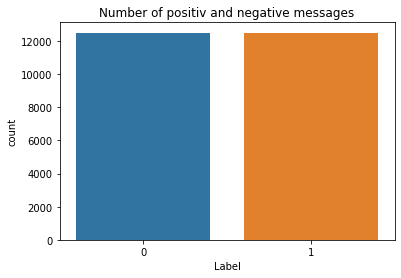

In [ ]:
sns.countplot(y_train)
plt.xlabel('Label')
plt.title('Number of positiv and negative messages')
plt.show()

## Initial model

In [ ]:
# truncate and pad input sequences
max_review_length = 500
X_train = pad_sequences(X_train, maxlen=max_review_length)
X_test = pad_sequences(X_test, maxlen=max_review_length)

In [ ]:
# create the model
def RNN2_1():
  embedding_vecor_length = 32
  model = Sequential()
  model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
  model.add(LSTM(100))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
model2_1 = RNN2_1()
model2_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, 
             batch_size=64, 
             callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience = 2)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
391/391 [==============================] - 29s 56ms/step - loss: 0.4711 - accuracy: 0.7783 - val_loss: 0.3451 - val_accuracy: 0.8561
Epoch 2/10
391/391 [==============================] - 23s 58ms/step - loss: 0.3307 - accuracy: 0.8656 - val_loss: 0.3543 - val_accuracy: 0.8552
Epoch 3/10
391/391 [=

In [ ]:
# Final evaluation of the model
scores = model2_1.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 86.06%


In [ ]:
import plotly.figure_factory as ff

x_axes = ['Negative', 'Positive']
y_axes =  ['Positive', 'Negative']

def conf_matrix(z, x=x_axes, y=y_axes):
    
    z = np.flip(z, 0)

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<b>Confusion matrix</b>',
                      xaxis = dict(title='Predicted value'),
                      yaxis = dict(title='Real value')
                     )

    # add colorbar
    fig['data'][0]['showscale'] = True
    
    return fig

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

Y_pred = (model2_1.predict(X_test)>0.5).astype(int)
print(metrics.accuracy_score(y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(y_test, Y_pred))

782/782 [==============================] - 7s 8ms/step
0.86056


In [ ]:
print(metrics.classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     12500
           1       0.86      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



### Add Dropout

In [ ]:
# create the model
def RNN_dropout():
  embedding_vecor_length = 32
  model = Sequential()
  model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
  model.add(Dropout(0.2))
  model.add(LSTM(100))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
model2_2 = RNN_dropout()
model2_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, 
             batch_size=64, 
             callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience = 2)])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           160000    
                                                                 
 dropout_4 (Dropout)         (None, 500, 32)           0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
391/391 [=======================

In [ ]:
# Final evaluation of the model
scores = model2_2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.75%


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

Y_pred = (model2_2.predict(X_test)>0.5).astype(int)
print(metrics.accuracy_score(y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(y_test, Y_pred))

782/782 [==============================] - 9s 11ms/step
0.85748


In [ ]:
print(metrics.classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.81      0.85     12500
           1       0.83      0.90      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



### Add Reccurent Dropout

In [ ]:
# create the model
def RNN_rec_dropout(top_words = 5000, embedding_vecor_length = 32, max_review_length = 500):
  model = Sequential()
  model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
model2_3 = RNN_rec_dropout()
model2_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, 
             batch_size=64, 
             callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience = 2)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
391/391 [==============================] - 778s 2s/step - loss: 0.4804 - accuracy: 0.7655 - val_loss: 0.3332 - val_accuracy: 0.8607
Epoch 2/10
391/391 [==============================] - 768s 2s/step - loss: 0.3002 - accuracy: 0.8806 - val_loss: 0.3633 - val_accuracy: 0.8450
Epoch 3/10
391/391 [===

In [ ]:
# Final evaluation of the model
scores = model2_3.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.12%


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

Y_pred = (model2_3.predict(X_test)>0.5).astype(int)
print(metrics.accuracy_score(y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(y_test, Y_pred))

782/782 [==============================] - 98s 125ms/step
0.8712


In [ ]:
print(metrics.classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.87     12500
           1       0.85      0.90      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



## Changed models

In [ ]:
# create the model
def RNN_modified(top_words = 5000, embedding_vecor_length = 32, max_review_length = 500):
  model = Sequential()
  model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
  model.add(LSTM(100, dropout=0.4, recurrent_dropout=0.2))
  model.add(Dense(128))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
model2_4 = RNN_modified(embedding_vecor_length = 64)
model2_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, 
             batch_size=64, 
             callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience = 2)])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 64)           320000    
                                                                 
 lstm_2 (LSTM)               (None, 100)               66000     
                                                                 
 dense_1 (Dense)             (None, 128)               12928     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 399,057
Trainable params: 399,057
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
391/391 [=======================

In [ ]:
# Final evaluation of the model
scores = model2_4.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.58%


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

Y_pred = (model2_4.predict(X_test)>0.5).astype(int)
print(metrics.accuracy_score(y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(y_test, Y_pred))

782/782 [==============================] - 98s 126ms/step
0.87576


In [ ]:
print(metrics.classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88     12500
           1       0.88      0.87      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



# LSTM та Convolutional Neural Network для класифікації послідовностей

In [ ]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

In [ ]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

# truncate and pad input sequences
max_review_length = 500
X_train = pad_sequences(X_train, maxlen=max_review_length)
X_test = pad_sequences(X_test, maxlen=max_review_length)

## Initial model

In [ ]:
# create the model
def RNN_CNN(top_words = 5000, embedding_vecor_length = 32, max_review_length = 500):
  model = Sequential()
  model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(LSTM(100))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
model3_1 = RNN_CNN()
model3_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, 
             batch_size=64, 
             callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience = 2)])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 32)           160000    
                                                                 
 conv1d (Conv1D)             (None, 500, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 250, 32)          0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
________________________________________________

In [ ]:
# Final evaluation of the model
scores = model3_1.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.98%


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

Y_pred = (model3_1.predict(X_test)>0.5).astype(int)
print(metrics.accuracy_score(y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(y_test, Y_pred))

782/782 [==============================] - 4s 5ms/step
0.8798


In [ ]:
print(metrics.classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88     12500
           1       0.90      0.86      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



## Changed model

In [ ]:
# create the model
def RNN_CNN2(top_words = 5000, embedding_vecor_length = 32, max_review_length = 500):
  model = Sequential()
  model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(LSTM(100))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
model3_2 = RNN_CNN2()
model3_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, 
             batch_size=64, 
             callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience = 2)])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 500, 32)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 32)           3104      
                                                                 
 conv1d_2 (Conv1D)           (None, 500, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 32)          0         
 1D)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 100)               53200     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                      

In [ ]:
# Final evaluation of the model
scores = model3_2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.55%


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

Y_pred = (model3_2.predict(X_test)>0.5).astype(int)
print(metrics.accuracy_score(y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(y_test, Y_pred))

782/782 [==============================] - 4s 5ms/step
0.88552


In [ ]:
print(metrics.classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88     12500
           1       0.87      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



LSTM+CNN+Dropout

In [ ]:
# create the model
def RNN_CNN_DO(top_words = 5000, embedding_vecor_length = 32, max_review_length = 500):
  model = Sequential()
  model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
  model.add(Dropout(0.4))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Dropout(0.6))
  model.add(LSTM(100))
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  print(model.summary())
  return model

In [ ]:
model3_3 = RNN_CNN_DO()
model3_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, 
             batch_size=64, 
             callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001, patience = 1)])

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 500, 32)           160000    
                                                                 
 dropout_32 (Dropout)        (None, 500, 32)           0         
                                                                 
 conv1d_29 (Conv1D)          (None, 500, 32)           3104      
                                                                 
 conv1d_30 (Conv1D)          (None, 500, 32)           3104      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 250, 32)          0         
 g1D)                                                            
                                                                 
 dropout_33 (Dropout)        (None, 250, 32)           0         
                                                     

In [ ]:
# Final evaluation of the model
scores = model3_3.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.83%


In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report

Y_pred = (model3_3.predict(X_test)>0.5).astype(int)
print(metrics.accuracy_score(y_test, Y_pred))

conf_matrix(metrics.confusion_matrix(y_test, Y_pred))

782/782 [==============================] - 4s 5ms/step
0.88832


In [ ]:
print(metrics.classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     12500
           1       0.90      0.87      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000

